In [ ]:
# INSTALL PACKAGES
# !pip install gpytorch

In [1]:
# LOAD PACKAGES
import warnings
import torch
from gpytorch.distributions import base_distributions
from gpytorch.functions import log_normal_cdf
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood
from gpytorch.constraints import Positive
from gpytorch.kernels import Kernel, ScaleKernel, RBFKernel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import gpytorch
import time as time

In [2]:
# check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
### CLASS DEFINITION AND INITIALIZATION
class BinomialLikelihood(_OneDimensionalLikelihood):
    r"""
    Implements the Binomial likelihood for count data y between 1 and m.
        The Binomial distribution is parameterized by :math:`m > 0`.
    We can write the likelihood as:

    .. math::
        \begin{equation*}
            p(Y=y|f,m)=\phi(f)^y(1-\phi(f))^{(m-y)}
        \end{equation*}
    """

# initialize the likelihood with the number of trials
    def __init__(self, n_trials):
        super().__init__()
        self.n_trials = n_trials

We first define a new class named `BinomialLilihood`, which inherits from `_OneDimensionalLikelihood`, a base class for one-dimensional likelihoods. 

We then define a initialization method with the parameter `n_trials`. Recall that our number of trials `m` is an integer greater than 0. We store the number of trials in the variable `self.n_trials`. 

In [5]:
### FORWARD 
# transforms function samples into Binomial distribution parameters
    def forward(self, function_samples, **kwargs):
        output_probs = base_distributions.Normal(0, 1).cdf(function_samples)
        print(output_probs.size())
        
        return base_distributions.Binomial(total_count=self.n_trials, probs=output_probs)


The function `forward` computes the likelihood given `function_samples`. The parameter `function_samples` samples from the latent function `f`. `**kwargs` represents additional keyword arguments. We first compute the CDF of a normal distribution by creating a standard normal distribution (`mean=0`, `variance=1`) and computing the CDF at the points specified by `function_samples`. This transforms `function_samples` into probabilities between 0 and 1, which is suitable for the Binomial likelihood's `probs` parameter. To ensure correct dimensionality, we print the shape (size) of the `output_probs` tensor. The function returns a binomial distribution object with 1) `total_count`, a set to the number of trials `self.n_trials`; and 2) `probs`, a set to the computed probabilities from the normal CDF (`output_probs`).

In [ ]:
### LOG MARGINAL 
# computes the log probability of observations under the marginal distribution
    def log_marginal(self, observations, function_dist, *args, **kwargs):
        marginal = self.marginal(function_dist, *args, **kwargs)
        return marginal.log_prob(observations)

The function `log_marginal` computes the logarithm of the marginal probability of the observations given the function distribution. The parameters 1) `observations` represents the observed count data; 2) `function_dist` indicates the distribution over the latent function `f`; and 3) `*args, **kwargs` represent additional positional and keyword arguments. 

The function calls the `marginal` to compute the marginal distribution based on `function_dist` and any additional arguments. It then returns the log probability of the `observations` under the computed `marginal` distribution. 

In [ ]:
### MARGINAL
# constructs the marginal Binomial distribution based on the function distribution's 
# mean and variance
    def marginal(self, function_dist, **kwargs):
        mean = function_dist.mean
        var = function_dist.variance
        link = mean.div(torch.sqrt(1 + var))
        output_probs = base_distributions.Normal(0, 1).cdf(link)
        return base_distributions.Binomial(total_count=self.num_data, probs=output_probs)

`marginal` computes the marginal distribution based on the function distribution. After extracting the mean and variance of the `function_dist`, it computes the link function by scaling the mean with the square root of `(1 + variance)`. The purpose of this transformation is to map the function distribution's parameters to the probability space suitable for the Binomial distribution. Similar to the `forward` function defined above, `output_probs` computes the CDF of a standard normal distribution at the transformed `link` values, which gives us probabilities between 0 and 1. The function returns a binomial distribution with 1) `total_count`, a set to `self.num_data`; and 2) `probs`, a set to the computed probabilities `output_probs`.

In [ ]:
### EXPECTED LOG PROBABILITY
# calculates the expected log probability of observations
    def expected_log_prob(self, observations, function_dist, *params, **kwargs):
        if torch.any(torch.logical_or(observations.le(-1), observations.ge(self.n_trials+1))):
            warnings.warn(
                "BinomialLikelihood.expected_log_prob expects observations with labels in [0, m]. "
                "Observations <0 or >m are not allowed.",
                DeprecationWarning,
            )
        else:
            for i in range(observations.size(0)):
                observations[i] = torch.clamp(observations[i],0,self.n_trials[i])

        log_prob_lambda = lambda function_samples: self.n_trials*log_normal_cdf(-function_samples) + \
                observations.mul(log_normal_cdf(function_samples)-log_normal_cdf(-function_samples))
        
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        
        return log_prob

The function `expected_log_prob` computes the expected log probability of the observations given the function distribution. The `if` statement checks if any observations are less than or equal to -1, or greater than or equal to `self.n_trials + 1`. This is to ensure that all observations lie within the valid range [0, m] for a binomial distribution. If any observations fall outside the valid range (exceeding the number of trials or being negative), we get a deprecation warning. The function iterates over each observation and clamps its value and make sure it lies witin `[0, self.n_trials[i]]`. 

We also define an inline log probability lambda function that calculates the log probability based on `function_samples`. `self.n_trials * log_normal_cdf(-function_samples)` computes the contribution from the failures and `observations.mul(log_normal_cdf(function_samples) - log_normal_cdf(-function_samples))` computes the contribution from successes. Note that `log_normal_cdf` is a function that computes the logarithm of the normal CDF.

Next, `lob_prob` calls the `quadrature` to numerically integrate the `log_prob_lambda` over the `function_dist`. The purpose of this line is to compute the expected log probability by integrating over the uncertainty in the function distribution. 

The function returns the computed expected log probability. 

In [6]:
# # implement Binomial Likelihood
# class BinomialLikelihood(_OneDimensionalLikelihood):
#     r"""
#     Implements the Binomial likelihood for count data y between 1 and m.
#         The Binomial distribution is parameterized by :math:`m > 0`.
#     We can write the likelihood as:

#     .. math::
#         \begin{equation*}
#             p(Y=y|f,m)=\phi(f)^y(1-\phi(f))^{(m-y)}
#         \end{equation*}
#     """

# # calculate total number of trials in the Binomial distribution
#     def __init__(self, n_trials):
#         super().__init__()
#         self.n_trials = n_trials

# # calculate CDF of a normal distribution with mean 0 and variance 1 at the 'function samples'
#     def forward(self, function_samples, **kwargs):
#         output_probs = base_distributions.Normal(0, 1).cdf(function_samples)
#         print(output_probs.size())
        
#         return base_distributions.Binomial(total_count=self.n_trials, probs=output_probs)

# # calculate the log marginal probabilities given the function distribution
#     def log_marginal(self, observations, function_dist, *args, **kwargs):
#         marginal = self.marginal(function_dist, *args, **kwargs)
#         return marginal.log_prob(observations)

# # compute the marginal distribution based on the mean and variance
#     def marginal(self, function_dist, **kwargs):
#         mean = function_dist.mean
#         var = function_dist.variance
#         link = mean.div(torch.sqrt(1 + var))
#         output_probs = base_distributions.Normal(0, 1).cdf(link)
#         return base_distributions.Binomial(total_count=self.num_data, probs=output_probs)

# # calculate the expected log probability of observation given the function distribution
#     def expected_log_prob(self, observations, function_dist, *params, **kwargs):
#         if torch.any(torch.logical_or(observations.le(-1), observations.ge(self.n_trials+1))):
#             # Remove after 1.0
#             warnings.warn(
#                 "BinomialLikelihood.expected_log_prob expects observations with labels in [0, m]. "
#                 "Observations <0 or >m are not allowed.",
#                 DeprecationWarning,
#             )
#         else:
#             for i in range(observations.size(0)):
#                 observations[i] = torch.clamp(observations[i],0,self.n_trials[i])

#         log_prob_lambda = lambda function_samples: self.n_trials*log_normal_cdf(-function_samples) + \
#                 observations.mul(log_normal_cdf(function_samples)-log_normal_cdf(-function_samples))
#         log_prob = self.quadrature(log_prob_lambda, function_dist)
#         return log_prob

In [7]:
# IMPLEMENT GP CLASS
gpytorch.settings.cholesky_jitter.value = 1e-4

class BinomialGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(BinomialGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.LinearMean(input_size=train_x.size(1))
        # ARD kernel for covariate, geospatial and time confounding
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.size(1)))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

We first add a small jitter to the diagonal of the covariance matrix during Cholesky decomposition. Cholesky decomposition can fail if the covariance matrix is not positive definite. The jitter mitigates this concern by making the matrix strictly positive definite. 

The `BinomialGPModel` class implements a GP model tailored for binomial likelihoods. It inherits from `gpytorch.models.ApproximateGP` that enables the use of variational inference for scalable GP models. 

`def __init__(self, train_x)` initializes the GP model with training data. `train_x` represents the input training data, which is a tensor of shape `(n_samples, n_features)`. `variational_distribution` defines the variational distribution that approximates the posterior over the latent function `f`. `CholeskyVariationalDistribution` represents a multivariate Gaussian distribution parameterized by a mean vector and a lower-triangular matrix (Cholesky  factor) for the covariance. `train_x.size(0)` specifies the number of variational parameters based on the number of training samples. 

`variational_strategy` defines the strategy for variational inference by specifying how the variational distribution interacts with the GP model. `self` refers to the current GP model instance; `train_x` specifies the input of training data; `variational_distribution` represents the variational distribution defined earlier; and `learn_inducing_locations=False` indicates whether the inducing points' locations should be learned during training. By setting it to `False`, we keep them fixed. 

We initialize the superclass `ApproximateGP` with the defined variational strategy. 

`self.mean_module` defines the mean function of the GP. `LinearMean` is a linear mean function that models the expected value of the latent function `f` as a linear combination of the input features. `input_size=train_x.size(1)` sets the number of input features based on the training data. 

`self.cover_module` defines the covariance (kernel) function of the GP. `ard_num_dims=train_x.size(1)` enables Automatic Relevance Determine (ARD) by assigning a separate lengthscale parameters to each input dimension. This allows the model to weigh the importance of each feature. Radial Basis Function (RBF) kernel measures similarity based on the distance between inputs, and Scale Kernel scales the output of the RBF kernel by a learned scalar factor to allow the model to adjust the overall variance. 

Finally, the `forward` defines the forward pass of the GP model that maps the inputs to a multivariate normal distribution over outputs. `x` is input data for which GP predictions are to be made. Using this, we compute the mean and covariance of the latent function `f`. We apply the linear mean function defined during initialization to the input `x` to compute the mean. This results in a mean vector of shape `(n_samples,)`. When computing the covariance matrix, we apply the scaled RBF kernel with ARD to the input `x`, resulting in a covariance matrix of shape `(n_samples, n_samples)`. 

The function returns a multivariate normal distribution representing the GP's predictions for the input `x`. 

In [12]:
def transform_data(data):
    n = data.shape[0] # number of samples in the dataset
    x = np.zeros((n, 6)) # initialize an input matrix with 6 columns

    # initialize target variables
    y = np.zeros((n,)) 
    theta = np.zeros((n,))
    N = np.zeros((n,))

    # encode gender as binary variables
    x[:,0] = (data["gender"] == "Male")
    x[:,1] = (data["gender"] == "Female")

    # encode race as binary variables
    x[:,2] = (data["race"] == "White")
    x[:,3] = (data["race"] == "Black")
    x[:,4] = (data["race"] == "Other")

    # year as a continuous variable
    x[:,5] = data["year"].to_numpy()

    # extract target variables
    theta = data["theta"].to_numpy()
    y = data["Y"].to_numpy()
    N = data["n"].to_numpy()
    
    return torch.from_numpy(x).float(), torch.from_numpy(y).float(),\
       torch.from_numpy(N).float(), torch.from_numpy(theta).float()

In [14]:
# load data
train_data = pd.read_csv("../Dataset/superSurvey_clean_train_data.csv", index_col=0)
test_data = pd.read_csv("../Dataset/superSurvey_clean_test_data.csv", index_col=0)

# transform data
train_x, train_y, train_N, train_theta = transform_data(train_data)
test_x, test_y, test_N, test_theta = transform_data(test_data)

# transfers the PyTorch tensors to GPU
train_x, train_y, train_N, train_theta = train_x.to(device), train_y.to(device), train_N.to(device), train_theta.to(device)
test_x, test_y, test_N, test_theta = test_x.to(device), test_y.to(device), test_N.to(device), test_theta.to(device)

# normalize data
train_x = (train_x - train_x.mean(0)) / train_x.std(0)
test_x = (test_x - test_x.mean(0)) / test_x.std(0)

# initialize likelihood and GP model
likelihood = BinomialLikelihood(n_trials=train_N).to(device)
model = BinomialGPModel(train_x=train_x).float().to(device)

training_iterations = 200

### Hyperparameter ###
# initialize the lengthscale hyperparameters of the GP's covariance function
# (lengthscale determines how much influence each input feature has on the GP's prediction)
# train_x.std(0, unbiased=False) computes the SD of each feature (column) in the training data
# unbiased=False ensures that the SD is calculated using the population formula (denominator n)
# rather than the sample formula (denominator n-1)
# 1 / train_x.std(0, unbiased=False) inverts the SD to set the initial lengthscales
# inversely proportional to the variability of each feature
# features with higher variability receive smaller initial lengthscales
# this indicates they might have a more significant impact on the model's predictions
lengthscale_init = 1 / train_x.std(0, unbiased=False)  

# calculate the proportion of successes (y) out of total trials (n) for each training sample
y_over_n = train_y / train_N

# clamp values to be within (0,1) since the inverse CDF is undefined at 0 and 1
y_over_n_clamped = y_over_n.clamp(min=0.001, max=0.999)

# transform the clamped proportion using the inverse CDF of the standard normal distribution 
# this maps the proportions to the latent variable space assumed by the GP model
theta_transformed = torch.distributions.Normal(0, 1).icdf(y_over_n_clamped)

# calculate the SD of the transformed data to set the inital output scale
output_scale_init = theta_transformed.std(unbiased=False).item()

# initialize hyperparameters
hypers = {
    'mean_module.bias': torch.tensor(0.),
    'covar_module.base_kernel.lengthscale': lengthscale_init,
    'covar_module.outputscale': torch.tensor(output_scale_init),
}
model.initialize(**hypers)

# put both the GP model and likelihood into training mode
model.train()
likelihood.train()

# initialize Adam optimizer to update model's parameters based on
# computed gradients during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# define the loss function (ELBO)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

start = time.time()

for i in range(training_iterations):
    # clear previously accumulated gradients to prevent them from being
    # mixed with the current iteration's gradients
    optimizer.zero_grad()

    # passes the training input features through the GP model to obtain the
    # predictive output
    output = model(train_x)
    
    # calculate the negative ELBO by evaluating the mll (variational ELBO)
    # on the model's output and the target variable train_y
    # minimizing negative ELBO = maximizing ELBO
    # this balances the data fit and model complexity 
    loss = -mll(output, train_y)

    # compute the gradients of the loss with respect to the model's parameters
    loss.backward()

    # update model's parameters on the computed gradients and the Adam's update rule
    optimizer.step()
    
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))

end = time.time()

print(f"Training completed in {end - start} seconds")

Iter 1/200 - Loss: 171.934
Iter 2/200 - Loss: 167.304
Iter 3/200 - Loss: 162.773
Iter 4/200 - Loss: 158.441
Iter 5/200 - Loss: 154.287
Iter 6/200 - Loss: 150.278
Iter 7/200 - Loss: 146.417
Iter 8/200 - Loss: 142.721
Iter 9/200 - Loss: 139.195
Iter 10/200 - Loss: 135.825
Iter 11/200 - Loss: 132.609
Iter 12/200 - Loss: 129.556
Iter 13/200 - Loss: 126.670
Iter 14/200 - Loss: 123.945
Iter 15/200 - Loss: 121.371
Iter 16/200 - Loss: 118.944
Iter 17/200 - Loss: 116.665
Iter 18/200 - Loss: 114.529
Iter 19/200 - Loss: 112.531
Iter 20/200 - Loss: 110.662
Iter 21/200 - Loss: 108.923
Iter 22/200 - Loss: 107.305
Iter 23/200 - Loss: 105.804
Iter 24/200 - Loss: 104.414
Iter 25/200 - Loss: 103.128
Iter 26/200 - Loss: 101.940
Iter 27/200 - Loss: 100.841
Iter 28/200 - Loss: 99.828
Iter 29/200 - Loss: 98.896
Iter 30/200 - Loss: 98.037
Iter 31/200 - Loss: 97.246
Iter 32/200 - Loss: 96.517
Iter 33/200 - Loss: 95.845
Iter 34/200 - Loss: 95.224
Iter 35/200 - Loss: 94.652
Iter 36/200 - Loss: 94.119
Iter 37/20

In [15]:
model.covar_module.base_kernel.lengthscale 

tensor([[2.3737, 2.3744, 1.4577, 1.4652, 1.9657, 0.7110]], device='cuda:0',
       grad_fn=<SoftplusBackward0>)

Text(0.5, 1.0, 'training data')

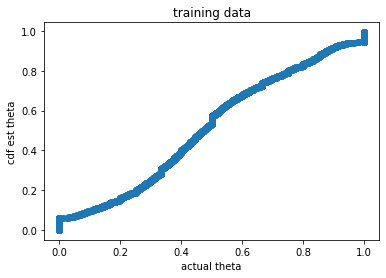

In [16]:
model.eval()
likelihood.eval()

with torch.no_grad():
    f_pred = model(train_x)
    mu = f_pred.mean.cpu().numpy()

if torch.is_tensor(train_theta) and train_theta.is_cuda:
    train_theta = train_theta.cpu().numpy()
elif not isinstance(train_theta, np.ndarray):
    train_theta = np.array(train_theta)

# calculate CDFs for test data
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf
    
sorted_train_theta, cdf_train_theta = calculate_cdf(train_theta)
sorted_mu, cdf_mu = calculate_cdf(mu)

# plotting the CDFs for test data
plt.scatter(sorted_train_theta, cdf_mu)
plt.xlabel("actual theta")
plt.ylabel("cdf est theta")
plt.title("training data")


Text(0.5, 1.0, 'testing data')

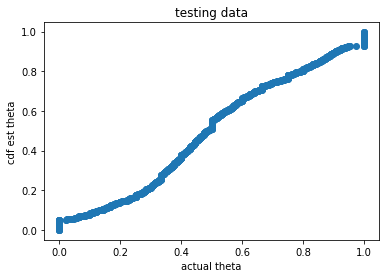

In [17]:
model.eval()
likelihood.eval()

with torch.no_grad():
    f_pred2 = model(test_x)
    mu2 = f_pred2.mean.cpu().numpy()

if torch.is_tensor(test_theta) and test_theta.is_cuda:
    test_theta = test_theta.cpu().numpy()
elif not isinstance(test_theta, np.ndarray):
    test_theta = np.array(test_theta)

# calculate CDFs for test data
sorted_test_theta, cdf_test_theta = calculate_cdf(test_theta)
sorted_mu2, cdf_mu2 = calculate_cdf(mu2)

# plotting the CDFs for test data
plt.scatter(sorted_test_theta,cdf_mu2)
plt.xlabel("actual theta")
plt.ylabel("cdf est theta")
plt.title("testing data")

In [ ]:
# !ls /content/drive/My\ Drive/Colab\ Notebooks/Model/

data.csv  Model_running.ipynb  rho.csv	test_data.csv  train_data.csv


In [50]:
# # path for saving
# model_path = "/home/alexis/Downloads/superSurvey_model.pth"
# optimizer_path = "/home/alexis/Downloads/superSurvey_optimizer.pth"

# # save the model state
# torch.save(model.state_dict(), model_path)

# # save the optimizer state
# torch.save(optimizer.state_dict(), optimizer_path)